In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM


In [50]:
df = pd.read_csv('m2_s2_bank_fd9e1495674488429597135792319d60__site_1239fca6caf920448b3cd13f6a2997af.csv')
df

,KeyTime,CellNo,ResistValue,VoltValue,TempValue
0,2020-02-14 16:04:04,1,0.444,4.45,22.8
1,2020-02-14 16:04:04,2,0.450,4.46,-20.0
2,2020-02-14 16:04:04,3,0.439,4.44,-20.0
3,2020-02-14 16:04:04,4,0.414,4.44,-20.0
4,2020-02-14 16:04:04,5,0.356,4.48,-20.0
...,...,...,...,...,...
62453,2021-02-03 08:46:44,92,0.414,4.49,-20.0
62454,2021-02-03 08:46:44,93,0.420,4.47,-20.0
62455,2021-02-03 08:46:44,94,0.426,4.49,-20.0
62456,2021-02-03 08:46:44,95,0.408,4.48,-20.0


## 온도 전처리

In [51]:
tmp=df['TempValue']
for x in range(len(tmp)):
    if tmp[x]==-20:
        tmp[x]=np.nan
filled_df = tmp.interpolate()
df['TempValue']=filled_df
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,KeyTime,CellNo,ResistValue,VoltValue,TempValue
0,2020-02-14 16:04:04,1,0.444,4.45,22.800
1,2020-02-14 16:04:04,2,0.450,4.46,22.775
2,2020-02-14 16:04:04,3,0.439,4.44,22.750
3,2020-02-14 16:04:04,4,0.414,4.44,22.725
4,2020-02-14 16:04:04,5,0.356,4.48,22.700
...,...,...,...,...,...
62453,2021-02-03 08:46:44,92,0.414,4.49,23.300
62454,2021-02-03 08:46:44,93,0.420,4.47,23.300
62455,2021-02-03 08:46:44,94,0.426,4.49,23.300
62456,2021-02-03 08:46:44,95,0.408,4.48,23.300


In [52]:
df = df[df['CellNo']==1].reset_index(drop=True)
df

,KeyTime,CellNo,ResistValue,VoltValue,TempValue
0,2020-02-14 16:04:04,1,0.444,4.45,22.8
1,2020-02-15 04:03:17,1,0.441,4.45,22.8
2,2020-02-15 16:02:38,1,0.437,4.46,22.8
3,2020-02-16 04:01:50,1,0.436,4.46,22.8
4,2020-02-16 16:01:08,1,0.436,4.45,22.7
...,...,...,...,...,...
649,2021-02-01 08:48:33,1,0.384,4.46,23.8
650,2021-02-01 20:48:02,1,0.385,4.45,23.9
651,2021-02-02 08:47:42,1,0.382,4.46,23.7
652,2021-02-02 20:47:10,1,0.388,4.46,23.6


## 함수 선언

In [53]:
def error_rate(original, prediction, ft_len, forecast_len):
    error_avg = []
    ft_len = ft_len-1
    for i in range(forecast_len):
      error = abs((original[ft_len+i] - prediction[-forecast_len+i]))/original[ft_len+i] * 100
      print('num',i,error,'actual',original[ft_len+i],'prediction',predictions[-forecast_len+i])
      print("오차율 :",error)
      error_avg.append(error)
    print('최소 오류값 :',min(error_avg))
    print('최대 오류값 :',max(error_avg))
    return sum(error_avg)/len(error_avg)

In [54]:

def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm for One Variable."""
    # (1) Prediction.
    x_pred = A * x_esti
    P_pred = A * P * A + Q

    # (2) Kalman Gain.
    K = P_pred * H / (H * P_pred * H + R)

    # (3) Estimation.
    x_esti = x_pred + K * (z_meas - H * x_pred)

    # (4) Error Covariance.
    P = P_pred - K * H * P_pred

    return x_esti, P
# Initialization for system model.
A = 1
H = 1
Q = 0.0001
R = 0.001
# Initialization for estimation.
x_0 = 10  # 14 for book.
P_0 = 6

In [55]:
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - (window_size+20)):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size+window_size-1]))
    return np.array(feature_list), np.array(label_list)

### 칼만필터 적용

In [56]:
n_samples = len(df)
x_0 = df['ResistValue'][1]
r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = df['ResistValue'][i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

df['ResistValue'] = r_esti_save
df

,KeyTime,CellNo,ResistValue,VoltValue,TempValue
0,2020-02-14 16:04:04,1,0.441000,4.45,22.8
1,2020-02-15 04:03:17,1,0.441000,4.45,22.8
2,2020-02-15 16:02:38,1,0.438905,4.46,22.8
3,2020-02-16 04:01:50,1,0.437789,4.46,22.8
4,2020-02-16 16:01:08,1,0.437205,4.45,22.7
...,...,...,...,...,...
649,2021-02-01 08:48:33,1,0.386832,4.46,23.8
650,2021-02-01 20:48:02,1,0.386337,4.45,23.9
651,2021-02-02 08:47:42,1,0.385165,4.46,23.7
652,2021-02-02 20:47:10,1,0.385931,4.46,23.6


## Scaling

In [57]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['ResistValue']
tmp = pd.DataFrame(df['ResistValue'])
tmp.columns = scale_cols
tmp_scaled = scaler.fit_transform(tmp[scale_cols])

tmp_scaled = pd.DataFrame(tmp_scaled)
tmp_scaled.columns = scale_cols
tmp_scaled

df['ResistValue']=tmp_scaled
df

,KeyTime,CellNo,ResistValue,VoltValue,TempValue
0,2020-02-14 16:04:04,1,1.000000,4.45,22.8
1,2020-02-15 04:03:17,1,1.000000,4.45,22.8
2,2020-02-15 16:02:38,1,0.968248,4.46,22.8
3,2020-02-16 04:01:50,1,0.951336,4.46,22.8
4,2020-02-16 16:01:08,1,0.942492,4.45,22.7
...,...,...,...,...,...
649,2021-02-01 08:48:33,1,0.179061,4.46,23.8
650,2021-02-01 20:48:02,1,0.171561,4.45,23.9
651,2021-02-02 08:47:42,1,0.153805,4.46,23.7
652,2021-02-02 20:47:10,1,0.165412,4.46,23.6


In [58]:
train=df
feature_cols = ['ResistValue','VoltValue','TempValue']
label_cols = ['ResistValue']

train_feature = train[feature_cols]
train_label = train[label_cols]
# test_feature = test[feature_cols]
# test_label = test[label_cols]



In [59]:
train_feature, train_label = make_dataset(train_feature, train_label, 20)
total_len = len(train_feature)

x_train = train_feature[:int(total_len*0.8)]
x_valid = train_feature[int(total_len*0.8):]
y_train = train_label[:int(total_len*0.8)]
y_valid = train_label[int(total_len*0.8):]

In [60]:
x_train.shape

(491, 20, 3)

In [61]:
model= Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2]), 
               activation='relu'))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               67584     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 77,953
Trainable params: 77,953
Non-trainable params: 0
_________________________________________________________________


In [62]:
from keras.callbacks import EarlyStopping
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
early_stop=EarlyStopping(monitor='val_loss', patience=5)

model.fit(x_train, y_train, epochs=100, batch_size=1)
model.save('Multi_Feature.h5')

Epoch 1/100
491/491 [==============================] - 5s 7ms/step - loss: 0.7518 - mse: 0.7518
Epoch 2/100
491/491 [==============================] - 3s 6ms/step - loss: 0.0690 - mse: 0.0690
Epoch 3/100
491/491 [==============================] - 3s 7ms/step - loss: 0.0567 - mse: 0.0567
Epoch 4/100
491/491 [==============================] - 3s 7ms/step - loss: 0.0421 - mse: 0.0421
Epoch 5/100
491/491 [==============================] - 3s 6ms/step - loss: 0.0360 - mse: 0.0360
Epoch 6/100
491/491 [==============================] - 3s 6ms/step - loss: 0.0358 - mse: 0.0358
Epoch 7/100
491/491 [==============================] - 3s 6ms/step - loss: 0.0301 - mse: 0.0301
Epoch 8/100
491/491 [==============================] - 3s 6ms/step - loss: 0.0311 - mse: 0.0311
Epoch 9/100
491/491 [==============================] - 3s 6ms/step - loss: 0.0339 - mse: 0.0339
Epoch 10/100
491/491 [==============================] - 3s 6ms/step - loss: 0.0365 - mse: 0.0365
Epoch 11/100
491/491 [=================

## Testing

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


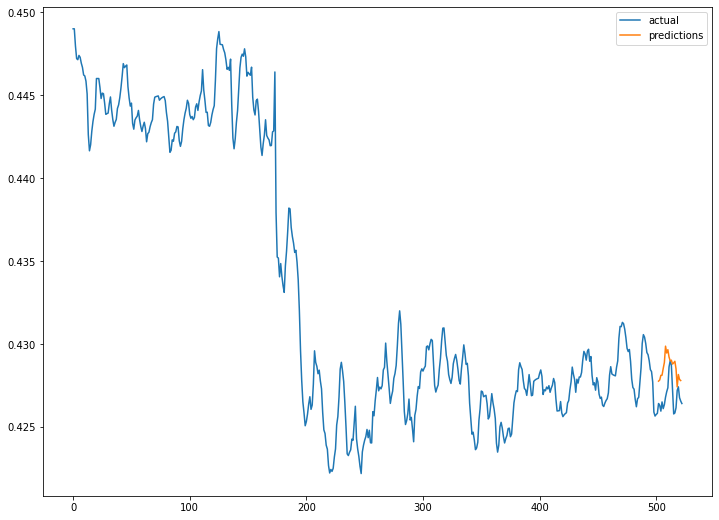

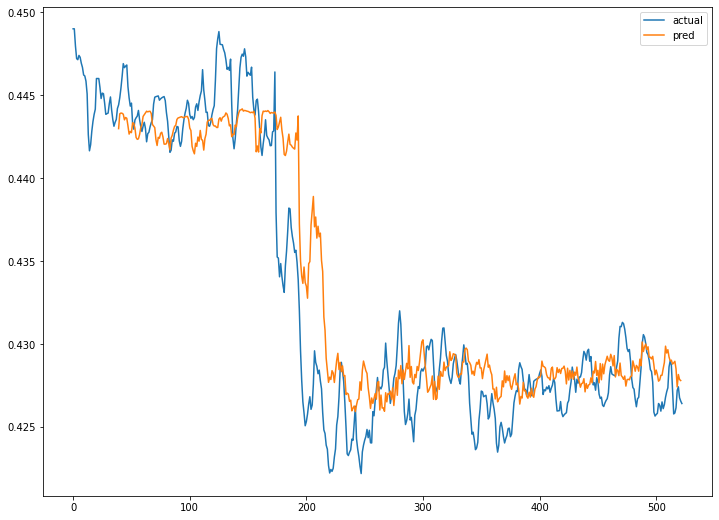

num 0 [0.20357716] actual [0.42862556] prediction [0.42775297]
오차율 : [0.20357716]
num 1 [0.08442978] actual [0.4281864] prediction [0.42782488]
오차율 : [0.08442978]
num 2 [0.00795479] actual [0.42813604] prediction [0.428102]
오차율 : [0.00795479]
num 3 [0.00308018] actual [0.42809929] prediction [0.42811248]
오차율 : [0.00308018]
num 4 [0.10341689] actual [0.42807247] prediction [0.42851517]
오차율 : [0.10341689]
num 5 [0.06620137] actual [0.4285932] prediction [0.42887694]
오차율 : [0.06620137]
num 6 [0.20737189] actual [0.42897326] prediction [0.42986283]
오차율 : [0.20737189]
num 7 [0.20477203] actual [0.43033126] prediction [0.42945006]
오차율 : [0.20477203]
num 8 [0.32549067] actual [0.43105224] prediction [0.4296492]
오차율 : [0.32549067]
num 9 [0.42472846] actual [0.43103813] prediction [0.42920738]
오차율 : [0.42472846]
num 10 [0.5391794] actual [0.43129798] prediction [0.4289725]
오차율 : [0.5391794]
num 11 [0.50986465] actual [0.43121748] prediction [0.42901886]
오차율 : [0.50986465]
num 12 [0.48915591] ac

In [83]:
df=pd.read_csv('m2_s2_bank_fc98de32534d5741a4304c4cdbca5b2d__site_1239fca6caf920448b3cd13f6a2997af.csv')
# tmp 전처리
tmp=df['TempValue']
for x in range(len(tmp)):
    if tmp[x]==-20:
        tmp[x]=np.nan
filled_df = tmp.interpolate()
df['TempValue']=filled_df

# Cell 1개 지정하기
df = df[df['CellNo']==13].reset_index(drop=True)

# 칼만필터 적용하기
n_samples = len(df)
x_0 = df['ResistValue'][1]
r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = df['ResistValue'][i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

df['ResistValue'] = r_esti_save


# Scaling
scale_cols = ['ResistValue']
tmp = pd.DataFrame(df['ResistValue'])
tmp.columns = scale_cols
tmp_scaled = scaler.fit_transform(tmp[scale_cols])

tmp_scaled = pd.DataFrame(tmp_scaled)
tmp_scaled.columns = scale_cols
tmp_scaled

df['ResistValue']=tmp_scaled
df = pd.DataFrame(df[['ResistValue', 'VoltValue','TempValue']])


# Making Datasets
train=df
feature_cols = ['ResistValue','VoltValue','TempValue']
label_cols = ['ResistValue']

train_feature2 = train[feature_cols]
train_label2 = train[label_cols]
train_feature2, train_label2 = make_dataset(train_feature2, train_label2, 20)

# Predicting
predictions = model.predict(train_feature2)

# Inversing
predictions = scaler.inverse_transform(predictions)
actual_data=df['ResistValue']
actual_data=pd.DataFrame(actual_data)
actual_data = scaler.inverse_transform(actual_data)


# Results
feature_len = len(df)-1 
plot_len = feature_len-20

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(actual_data[:], label ='actual')
plt.plot(x_data[plot_len:], predictions[-20:], label='predictions')
plt.legend()
plt.show()

plt.figure(figsize=(12, 9))
plt.plot(actual_data[:], label ='actual')
plt.plot(x_data[39:],predictions, label='pred')
plt.legend()
plt.show()


feature_len = len(train_feature2) - 1
plot_len = feature_len-20
error= error_rate(actual_data, predictions, plot_len, 20)
print('평균 오차율 :',error)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


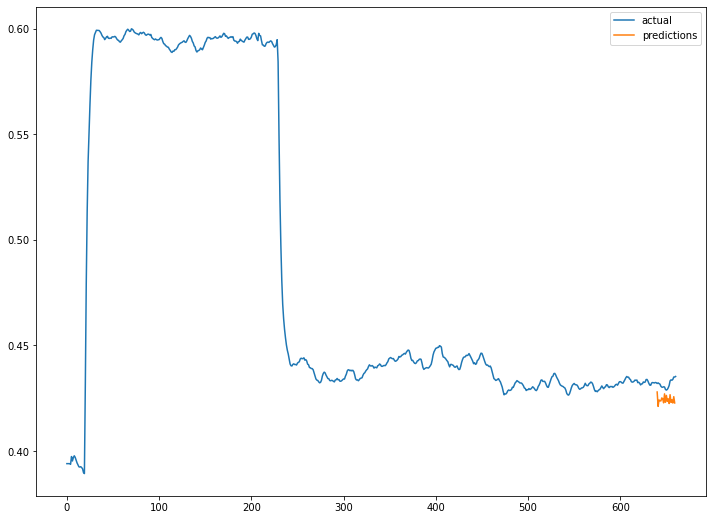

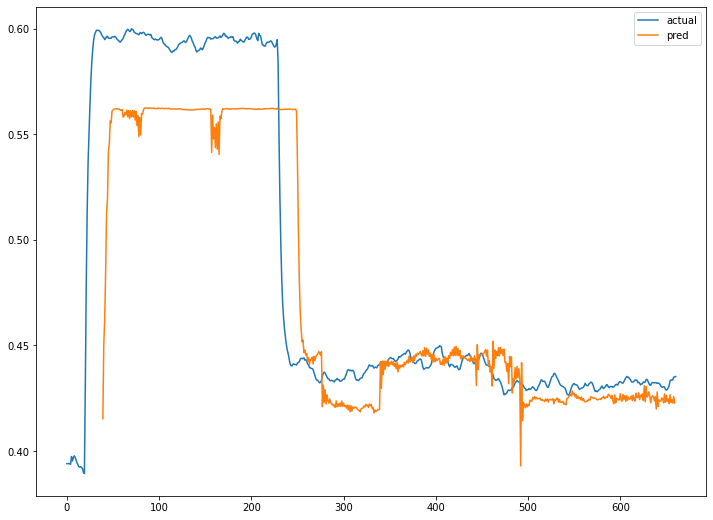

num 0 [1.11567218] actual [0.43274767] prediction [0.42791963]
오차율 : [1.11567218]
num 1 [2.70272426] actual [0.43281584] prediction [0.42111802]
오차율 : [2.70272426]
num 2 [1.95087486] actual [0.43259544] prediction [0.42415604]
오차율 : [1.95087486]
num 3 [1.9415005] actual [0.43216442] prediction [0.42377394]
오차율 : [1.9415005]
num 4 [1.95460085] actual [0.43212] prediction [0.42367378]
오차율 : [1.95460085]
num 5 [1.79797951] actual [0.43289805] prediction [0.42511463]
오차율 : [1.79797951]
num 6 [2.07879623] actual [0.43373606] prediction [0.42471957]
오차율 : [2.07879623]
num 7 [2.72362965] actual [0.43461783] prediction [0.42278045]
오차율 : [2.72362965]
num 8 [1.88835824] actual [0.43526139] prediction [0.4270421]
오차율 : [1.88835824]
num 9 [2.73057135] actual [0.43492062] prediction [0.4230448]
오차율 : [2.73057135]
num 10 [1.98571511] actual [0.43494206] prediction [0.42630535]
오차율 : [1.98571511]
num 11 [2.45622586] actual [0.43414725] prediction [0.4234836]
오차율 : [2.45622586]
num 12 [2.1102362] act

In [84]:
df=pd.read_csv('m2_s2_bank_0765f177a52e5543a9e0a8bfc045cf6a__site_40ab7c891c559b478e96f8bb5c682ca0.csv')
# tmp 전처리
tmp=df['TempValue']
for x in range(len(tmp)):
    if tmp[x]==-20:
        tmp[x]=np.nan
filled_df = tmp.interpolate()
df['TempValue']=filled_df

# Cell 1개 지정하기
df = df[df['CellNo']==4].reset_index(drop=True)

# 칼만필터 적용하기
n_samples = len(df)
x_0 = df['ResistValue'][1]
r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = df['ResistValue'][i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

df['ResistValue'] = r_esti_save


# Scaling
scale_cols = ['ResistValue']
tmp = pd.DataFrame(df['ResistValue'])
tmp.columns = scale_cols
tmp_scaled = scaler.fit_transform(tmp[scale_cols])

tmp_scaled = pd.DataFrame(tmp_scaled)
tmp_scaled.columns = scale_cols
tmp_scaled

df['ResistValue']=tmp_scaled
df = pd.DataFrame(df[['ResistValue', 'VoltValue','TempValue']])


# Making Datasets
train=df
feature_cols = ['ResistValue','VoltValue','TempValue']
label_cols = ['ResistValue']

train_feature2 = train[feature_cols]
train_label2 = train[label_cols]
train_feature2, train_label2 = make_dataset(train_feature2, train_label2, 20)

# Predicting
predictions = model.predict(train_feature2)

# Inversing
predictions = scaler.inverse_transform(predictions)
actual_data=df['ResistValue']
actual_data=pd.DataFrame(actual_data)
actual_data = scaler.inverse_transform(actual_data)


# Results
feature_len = len(df)-1 
plot_len = feature_len-20

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(actual_data[:], label ='actual')
plt.plot(x_data[plot_len:], predictions[-20:], label='predictions')
plt.legend()
plt.show()

plt.figure(figsize=(12, 9))
plt.plot(actual_data[:], label ='actual')
plt.plot(x_data[39:],predictions, label='pred')
plt.legend()
plt.show()


feature_len = len(train_feature2) - 1
plot_len = feature_len-20
error= error_rate(actual_data, predictions, plot_len, 20)
print('평균 오차율 :',error)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


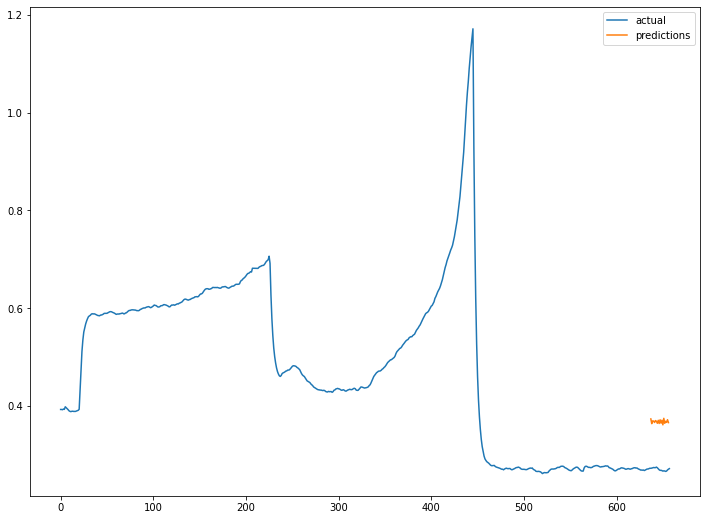

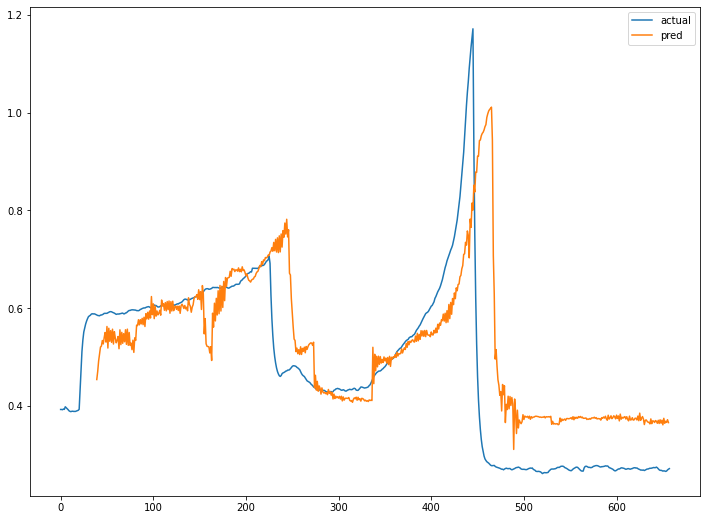

num 0 [38.23620445] actual [0.26958372] prediction [0.3726623]
오차율 : [38.23620445]
num 1 [35.54365031] actual [0.26780509] prediction [0.3629928]
오차율 : [35.54365031]
num 2 [38.35841314] actual [0.26650696] prediction [0.3687348]
오차율 : [38.35841314]
num 3 [38.23775161] actual [0.26637] prediction [0.3682239]
오차율 : [38.23775161]
num 4 [36.5158633] actual [0.26762083] prediction [0.36534488]
오차율 : [36.5158633]
num 5 [37.37327066] actual [0.26880389] prediction [0.3692647]
오차율 : [37.37327066]
num 6 [36.14551857] actual [0.27020765] prediction [0.3678756]
오차율 : [36.14551857]
num 7 [34.64084595] actual [0.27015155] prediction [0.36373433]
오차율 : [34.64084595]
num 8 [36.36710972] actual [0.27119123] prediction [0.36981565]
오차율 : [36.36710972]
num 9 [33.33666932] actual [0.27249035] prediction [0.36332956]
오차율 : [33.33666932]
num 10 [36.17454116] actual [0.27235788] prediction [0.3708821]
오차율 : [36.17454116]
num 11 [33.82217144] actual [0.27199104] prediction [0.36398432]
오차율 : [33.82217144]
nu

In [85]:
df=pd.read_csv('m2_s2_bank_0765f177a52e5543a9e0a8bfc045cf6a__site_40ab7c891c559b478e96f8bb5c682ca0.csv')
# tmp 전처리
tmp=df['TempValue']
for x in range(len(tmp)):
    if tmp[x]==-20:
        tmp[x]=np.nan
filled_df = tmp.interpolate()
df['TempValue']=filled_df

# Cell 1개 지정하기
df = df[df['CellNo']==20].reset_index(drop=True)

# 칼만필터 적용하기
n_samples = len(df)
x_0 = df['ResistValue'][1]
r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = df['ResistValue'][i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

df['ResistValue'] = r_esti_save


# Scaling
scale_cols = ['ResistValue']
tmp = pd.DataFrame(df['ResistValue'])
tmp.columns = scale_cols
tmp_scaled = scaler.fit_transform(tmp[scale_cols])

tmp_scaled = pd.DataFrame(tmp_scaled)
tmp_scaled.columns = scale_cols
tmp_scaled

df['ResistValue']=tmp_scaled
df = pd.DataFrame(df[['ResistValue', 'VoltValue','TempValue']])


# Making Datasets
train=df
feature_cols = ['ResistValue','VoltValue','TempValue']
label_cols = ['ResistValue']

train_feature2 = train[feature_cols]
train_label2 = train[label_cols]
train_feature2, train_label2 = make_dataset(train_feature2, train_label2, 20)

# Predicting
predictions = model.predict(train_feature2)

# Inversing
predictions = scaler.inverse_transform(predictions)
actual_data=df['ResistValue']
actual_data=pd.DataFrame(actual_data)
actual_data = scaler.inverse_transform(actual_data)


# Results
feature_len = len(df)-1 
plot_len = feature_len-20

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(actual_data[:], label ='actual')
plt.plot(x_data[plot_len:], predictions[-20:], label='predictions')
plt.legend()
plt.show()

plt.figure(figsize=(12, 9))
plt.plot(actual_data[:], label ='actual')
plt.plot(x_data[39:],predictions, label='pred')
plt.legend()
plt.show()


feature_len = len(train_feature2) - 1
plot_len = feature_len-20
error= error_rate(actual_data, predictions, plot_len, 20)
print('평균 오차율 :',error)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


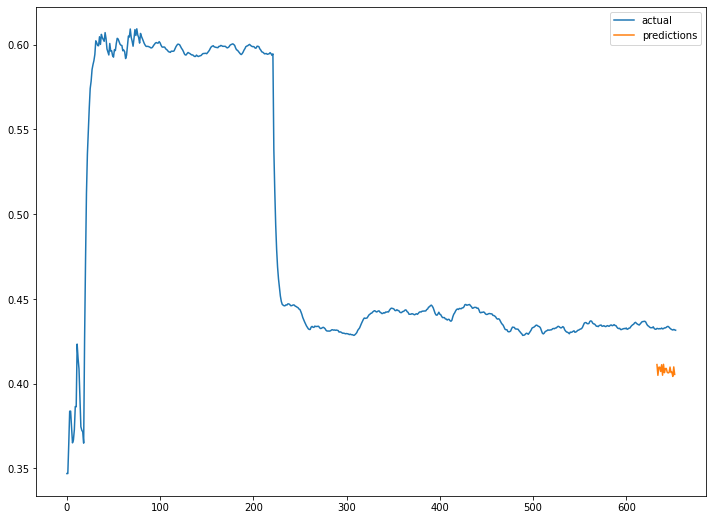

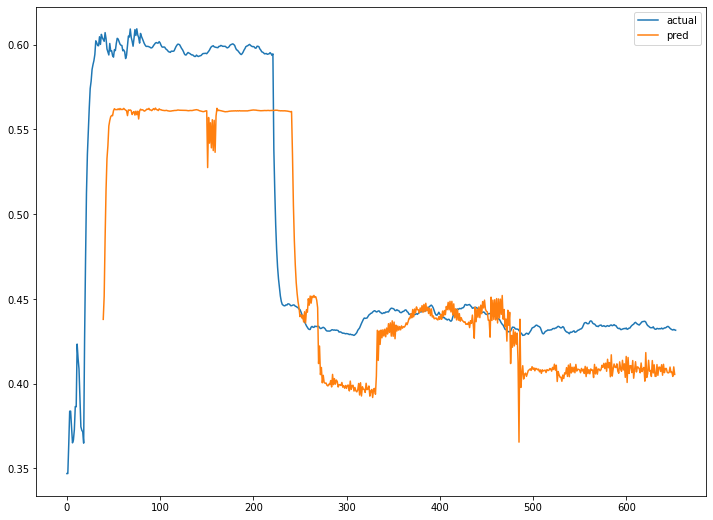

num 0 [4.91387601] actual [0.43253423] prediction [0.41128004]
오차율 : [4.91387601]
num 1 [6.40750273] actual [0.43266006] prediction [0.40493736]
오차율 : [6.40750273]
num 2 [5.14629174] actual [0.43194143] prediction [0.40971246]
오차율 : [5.14629174]
num 3 [5.13976916] actual [0.43195725] prediction [0.40975565]
오차율 : [5.13976916]
num 4 [5.78987701] actual [0.43223896] prediction [0.40721285]
오차율 : [5.78987701]
num 5 [4.91368233] actual [0.43244456] prediction [0.4111956]
오차율 : [4.91368233]
num 6 [6.37680887] actual [0.43259461] prediction [0.40500888]
오차율 : [6.37680887]
num 7 [4.85507725] actual [0.43243398] prediction [0.41143897]
오차율 : [4.85507725]
num 8 [6.09014563] actual [0.43285705] prediction [0.40649542]
오차율 : [6.09014563]
num 9 [5.3588314] actual [0.4320852] prediction [0.40893048]
오차율 : [5.3588314]
num 10 [5.40094472] actual [0.43233234] prediction [0.4089823]
오차율 : [5.40094472]
num 11 [6.0186704] actual [0.43278287] prediction [0.4067351]
오차율 : [6.0186704]
num 12 [6.12013065] ac

In [86]:
df=pd.read_csv('m2_s2_bank_0765f177a52e5543a9e0a8bfc045cf6a__site_40ab7c891c559b478e96f8bb5c682ca0.csv')
# tmp 전처리
tmp=df['TempValue']
for x in range(len(tmp)):
    if tmp[x]==-20:
        tmp[x]=np.nan
filled_df = tmp.interpolate()
df['TempValue']=filled_df

# Cell 1개 지정하기
df = df[df['CellNo']==87].reset_index(drop=True)

# 칼만필터 적용하기
n_samples = len(df)
x_0 = df['ResistValue'][1]
r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = df['ResistValue'][i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

df['ResistValue'] = r_esti_save


# Scaling
scale_cols = ['ResistValue']
tmp = pd.DataFrame(df['ResistValue'])
tmp.columns = scale_cols
tmp_scaled = scaler.fit_transform(tmp[scale_cols])

tmp_scaled = pd.DataFrame(tmp_scaled)
tmp_scaled.columns = scale_cols
tmp_scaled

df['ResistValue']=tmp_scaled
df = pd.DataFrame(df[['ResistValue', 'VoltValue','TempValue']])


# Making Datasets
train=df
feature_cols = ['ResistValue','VoltValue','TempValue']
label_cols = ['ResistValue']

train_feature2 = train[feature_cols]
train_label2 = train[label_cols]
train_feature2, train_label2 = make_dataset(train_feature2, train_label2, 20)

# Predicting
predictions = model.predict(train_feature2)

# Inversing
predictions = scaler.inverse_transform(predictions)
actual_data=df['ResistValue']
actual_data=pd.DataFrame(actual_data)
actual_data = scaler.inverse_transform(actual_data)


# Results
feature_len = len(df)-1 
plot_len = feature_len-20

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(actual_data[:], label ='actual')
plt.plot(x_data[plot_len:], predictions[-20:], label='predictions')
plt.legend()
plt.show()

plt.figure(figsize=(12, 9))
plt.plot(actual_data[:], label ='actual')
plt.plot(x_data[39:],predictions, label='pred')
plt.legend()
plt.show()


feature_len = len(train_feature2) - 1
plot_len = feature_len-20
error= error_rate(actual_data, predictions, plot_len, 20)
print('평균 오차율 :',error)